<a href="https://colab.research.google.com/github/hwarang97/paperswithcode/blob/main/InceptionNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
from torch import nn, optim
from google.colab import drive

!pip install torchinfo
from torchinfo import summary

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import time

!pip install albumentations
import albumentations as A
import cv2

import matplotlib.pyplot as plt

import numpy as np

drive.mount('/content/drive')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# hyper parameters

In [ ]:
# aumentations
crop_size = 224

# model
root = '/content/drive/MyDrive/Colab Notebooks/data'
BATCH_SIZE = 64
LR = 2e-3
LR_STEP = 8
GAMMA = 4e-2
EPOCH = 5
criterion = nn.CrossEntropyLoss()
MOMENTUM = 0.9
num_classes = 1000
dataset = ''

# dataset and dataloader
RoT = 0.8

# Augmentation

In [ ]:
def custom_augmentations(image):

    height, width = image.shape[0], image.shape[1]

    crop_sizes = [256, 288, 320, 352]
    crop_size = crop_sizes[np.random.randint(len(crop_sizes))]

    transform_list = []

    # width, hegith 중에서 작은 쪽을 256, 288, 320, 352로 사이즈 변경
    # 가로가 인 경우 왼,중,오 / 세로가 긴 경우 위, 중 ,아래로 crop
    if width <= height:
        transform_list += [A.Resize(height=height, width=crop_size),]
        transform_list += [A.OneOf([
                                    A.Crop(x_min=0, y_min=0, x_max=crop_size, y_max=crop_size),  # 상
                                    A.Crop(x_min=0, y_min=(height-crop_size)//2, x_max=crop_size, y_max=(height+crop_size)//2), # 중
                                    A.Crop(x_min=0, y_min=height-crop_size, x_max=crop_size, y_max=height) # 하
                                    ], p=1)]

    else:
        transform_list += [A.Resize(height=crop_size, width=width)] # 552, 352
        transform_list += [A.OneOf([
                                    A.Crop(x_min=0, y_min=0, x_max=crop_size, y_max=crop_size), #좌
                                    A.Crop(x_min=(width-crop_size)//2, y_min=0, x_max=(width+crop_size)//2, y_max=crop_size), # 중
                                    A.Crop(x_min=(width-crop_size), y_min=0, x_max=width, y_max=crop_size) # 우
                                    ], p=1)]

    transform = A.Compose(transform_list)
    augmented_img = transform(image=image)['image']
    cropped_height, cropped_width = augmented_img.shape[0], augmented_img[1]

    # 224x224 로 네 모서리, 가운데와 전체를 224x224로 변경
    print(f'height: {height}, width: {width}, crop_size: {crop_size}')
    transfrom = ([A.OneOf([
                 A.Crop(x_min=0, y_min=0, x_max=224, y_max=224), # 좌상단
                 A.Crop(x_min=0, y_min=cropped_height-224, x_max=224, y_max=cropped_height), # 좌하단
                 A.Crop(x_min=cropped_width-224, y_min=0, x_max=cropped_width, y_max=224), # 우상단
                 A.Crop(x_min=cropped_width-224, y_min=cropped_height-224, x_max=cropped_width, y_max=cropped_height), # 우하단
                 A.CenterCrop(height=224, width=224),
                 A.Resize(height=224, width=224)
                 ],p=1),
                 A.HorizontalFlip(),
                 # A.ToTensorV2()
    ])
    return transform(image=image)['image']

In [ ]:
def visualize(image):
    plt.figure(figsize=(10,10)),
    plt.axis('off')
    plt.imshow(image)

height: 365, width: 552, crop_size: 256


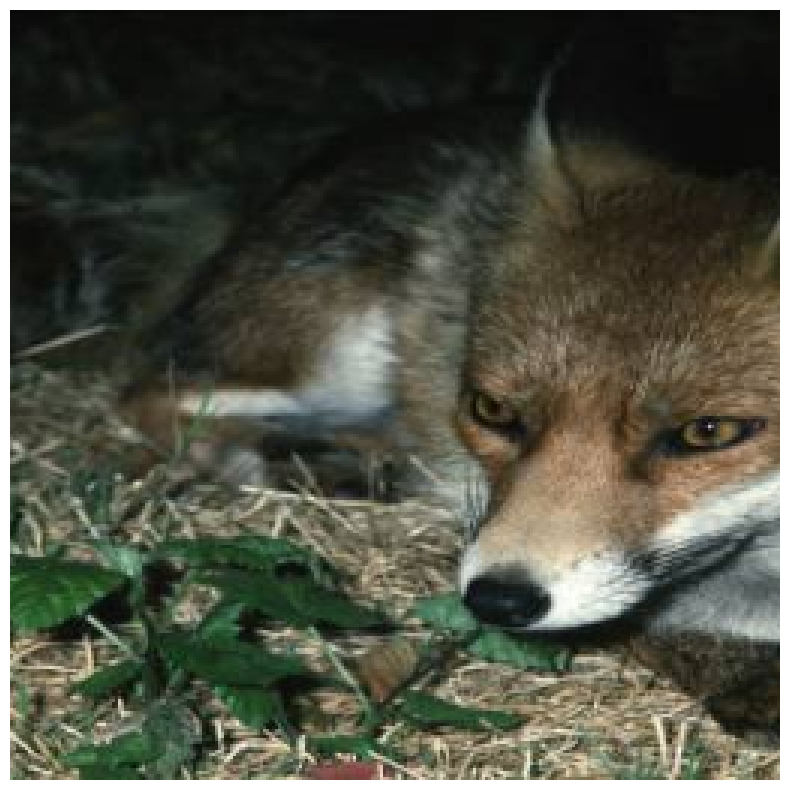

In [ ]:
img = cv2.imread('/content/n02118333_27_fox.jpg') # BGR foramt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB format
augmented_image = custom_augmentations(image=img)
visualize(augmented_image)

# Train and Test

In [ ]:
# 이미지넷을 사용하기에는 데이터가 너무 커서 틀만 만들고 마무리

transform = transforms.ToTensor()

train_DS = datasets.ImageNet(root=root, split='train', download=True, transform=transform)
NoT = int(RoT*len(train_DS)); NoV = len(train_DS) - NoT
train_DS, val_DS = torch.utils.data.random_split(train_DS, [NoT, NoV])

test_DS = datasets.ImageNet(root=root, split='val', download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def Train(model, train_DL, val_DL, criterion, optimizer,
          EPOCH, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path, **kwargs):

    if 'LR_STEP' in kwargs:
        scheduler = StepLR(optimizer, stop_size=kwargs['LR_STEP'], gamma=kwargs['LR_GAMMA'])
    else:
        # scheduler 변수가 참조될 때, 선언이 안되었을 경우에 대비해서 만듬
        scheduler = None

    loss_history = {'train': [], 'val': []}
    acc_history = {'train': [], 'val': []}
    best_loss = 9999

    for ep in range(EPOCH):
        epoch_start = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch: {ep+1}, current_LR = {current_lr}')

        model.train()
        train_loss, train_acc, _ = loss_epoch(model, train_DL, criterion, optimizer)
        loss_history['train'] += [train_loss]
        acc_history['train'] += [train_acc]

        model.eval()
        with torch.no_grad():
            val_loss, val_acc, _ = loss_epoch(model, val_DL, criterion, optimizer)
            loss_history['val'] += [val_loss]
            acc_history['val'] += [val_acc]

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({'model': model,
                            'ep': ep,
                            'optimizer': optimizer,
                            'scheduler': scheduler}, save_model_path)

    if 'LR_STEP' in kwargs:
        scheduler.step()

    print(f'train loss: {round(train_loss,5)}, '
    f'val loss: {round(val_loss,5)} \n'
    f'train acc: {round(train_acc,1)} %, '
    f'val acc: {round(val_acc, 1)} %, time: {round(time.time()-epoch_start)} s')
    print('-'*20)

    torch.save({'loss_history': loss_history,
                'acc_history': acc_history,
                'batch_size': BATCH_SIZE,
                'train_ratio': TRAIN_RATIO}, save_history_path)

    return loss_history

def Test(model, test_DL, criterion):
    model.eval()
    with torch.no_grad():
        test_loss, test_acc, correct = loss_epoch(model, test_DL, criterion)
    print()
    print(f'Test loss: {round(test_loss, 5)}')
    print(f'Test accuracy: {correct}/{len(test_DL.dataset)} ({round(correct/len(test_DL.dataset)*100,1)}) %')
    return round(test_acc,1)

def loss_epoch(model, DL, criterion, optimizer=None):
    N = len(DL.dataset)
    eloss = 0; correct = 0

    for x_batch, y_batch in tqdm(DL, leave=False):
        x_batch = x_batch.to(DEVICE); y_batch = y_batch.to(DEVICE)
        # inference
        aux1, aux2, y_hat = model(x_batch)
        # loss
        loss = loss = criterion(y_hat, y_batch) + 0.3(criterion(aux1, y_batch)+criterion(aux2, y_batch))
        # update
        if model.training and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # loss accumulateion
        bloss = loss.item() * x_batch.shape[0]
        sloss += bloss
        # correct
        correct += torch.sum(y_batch == y_hat.argmax(dim=1).item())

    eloss = sloss/N
    accuracy = correct/N * 100

    return eloss, accuracy, correct

def Test_plot(test_DL. *models):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hats = []

        for model in models:
            y_hats += [model(x_batch)]

        ensumbled_y_hat = sum(y_hats) / len(models)
        pred = ensumbled_y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu")
    pred = pred.to('cpu')

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")

def im_plot(DL):
    x_batch, y_batch = next(iter(DL))
    plt.figure(figsize=(8,4))
    for idx in range(6):
        im = x_batch[idx]
        im = im-im.min() # for imshow clipping
        im = im/im.max() # for imshow clipping

        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(im.permute(1,2,0).squeeze())
        true_class = DL.dataset.classes[y_batch[idx]]
        plt.title(true_class, color = "g")
    print(f"x_batch size = {x_batch.shape}")

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [ ]:
model1 = InceptionNet_V1(num_classes)
model2 = InceptionNet_V1(num_classes)
model3 = InceptionNet_V1(num_classes)
model4 = InceptionNet_V1(num_classes)
model5 = InceptionNet_V1(num_classes)
model6 = InceptionNet_V1(num_classes)
model7 = InceptionNet_V1(num_classes)
models = [model1, model2, model3, model4, model5, model6, model7]

optimizer1 = optim.SGD(model1.parameters(), lr=LR, momentum = MOMENTUM)
optimizer2 = optim.SGD(model2.parameters(), lr=LR, momentum = MOMENTUM)
optimizer3 = optim.SGD(model3.parameters(), lr=LR, momentum = MOMENTUM)
optimizer4 = optim.SGD(model4.parameters(), lr=LR, momentum = MOMENTUM)
optimizer5 = optim.SGD(model5.parameters(), lr=LR, momentum = MOMENTUM)
optimizer6 = optim.SGD(model6.parameters(), lr=LR, momentum = MOMENTUM)
optimizer7 = optim.SGD(model7.parameters(), lr=LR, momentum = MOMENTUM)
optimizers = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5, optimizer6, optimizer7]

for model, optimizer in zip(models, optimizers):
    Train(model, train_DL, val_DL, criterion, optimizer,
            EPOCH, BATCH_SIZE, TRAIN_RATIO,
            save_model_path, save_history_path, **kwargs)

for model in models:
    Test(test_DL, model)

count_params(model1)

# Inception Model

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.convblock = nn.Sequential(nn.Conv2d(in_channels, out_channels, bias=False, **kwargs),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU())

    def forward(self, x):
        output = self.convblock(x)
        return output

class InceptionNet(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool):
        super().__init__()
        self.path1 = nn.Sequential(BasicConv2d(in_channels, ch1x1, kernel_size=1))
        self.path2 = nn.Sequential(BasicConv2d(in_channels, ch3x3red, kernel_size=1),
                                   BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1))
        self.path3 = nn.Sequential(BasicConv2d(in_channels, ch5x5red, kernel_size=1),
                                   BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2))
        self.path4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                   BasicConv2d(in_channels, pool, kernel_size=1))

    def forward(self, x):
        output1 = self.path1(x)
        output2 = self.path2(x)
        output3 = self.path3(x)
        output4 = self.path4(x)
        output = [output1, output2, output3, output4]
        return torch.concat(output, dim=1) # dim=1, num*ch*row*col

class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.path = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=3),
                                  BasicConv2d(in_channels, 128, kernel_size=1),
                                  nn.Flatten(start_dim=1),
                                  nn.Linear(2048, 1028, bias=False),
                                  nn.ReLU(),
                                  nn.Dropout2d(p=0.7),
                                  nn.Linear(1028, num_classes))

    def forward(self, x):
        output = self.path(x)
        return output

class InceptionNet_V1(nn.Module):
    def __init__(self, num_classes, init_weights=None):
        super().__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.max1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = BasicConv2d(64, 192, kernel_size=3, stride=1)

        self.max2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.incept3a = InceptionNet(192, 64, 96, 128, 16, 32, 32)
        self.incept3b = InceptionNet(256, 128, 128, 192, 32, 96, 64)

        self.max3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.incept4a = InceptionNet(480, 192, 96, 208, 16, 48, 64)
        self.incept4b = InceptionNet(512, 160, 112, 224, 24, 64, 64)
        self.incept4c = InceptionNet(512, 128, 128, 256, 24, 64, 64)
        self.incept4d = InceptionNet(512, 112, 144, 288, 32, 64, 64)
        self.incept4e = InceptionNet(528, 256, 160, 320, 32, 128, 128)

        self.max4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.incept5a = InceptionNet(832, 256, 160, 320, 32, 128, 128)
        self.incept5b = InceptionNet(832, 384, 192, 384, 48, 128, 128)
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        self.linear = nn.Linear(1024, num_classes)

        if self.training:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = None
            self.axu2 = None

        # weiths innitialization
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    torch.nn.init.trunc_normal_(m.weight, mean=0., std=0.01, a=-2, b=2) # -2 ~ 2 사이의 정규분포값 추출
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):

        x = self.conv1(x)    # 64x112x112
        x = self.max1(x)     # 64x56x56
        x = self.conv2(x)    # 192x56x56

        x = self.max2(x)     # 192x28x28
        x = self.incept3a(x) # 256x28x28
        x = self.incept3b(x) # 480x28x28

        x = self.max3(x)     # 480x14x14
        x = self.incept4a(x) # 512x14x14

        if self.aux1 is not None and self.training:
            aux1 = self.aux1(x)
        x = self.incept4b(x) # 512x14x14
        x = self.incept4c(x) # 512x14x14
        x = self.incept4d(x) # 528x14x14

        if self.aux2 is not None and self.training:
            aux2 = self.aux2(x)

        x = self.incept4e(x) # 832x14x14

        x = self.max4(x)     # 832x7x7
        x = self.incept5a(x) # 832x7x7
        x = self.incept5b(x) # 1024x7x7

        x = self.avg(x)      # 1024x1x1
        x = torch.flatten(x, start_dim=1)
        x = torch.dropout(x, p=0.7, train=True)
        x = self.linear(x) # 1000x1x1

        if self.training:
            return aux1, aux2, x
        else:
            return x

In [ ]:
a = InceptionNet_V1(1000)
a.train()
summary(a, input_size=(10,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
InceptionNet_V1                               [10, 1000]                6,402,320
├─BasicConv2d: 1-1                            [10, 64, 112, 112]        --
│    └─Sequential: 2-1                        [10, 64, 112, 112]        --
│    │    └─Conv2d: 3-1                       [10, 64, 112, 112]        9,408
│    │    └─BatchNorm2d: 3-2                  [10, 64, 112, 112]        128
│    │    └─ReLU: 3-3                         [10, 64, 112, 112]        --
├─MaxPool2d: 1-2                              [10, 64, 56, 56]          --
├─BasicConv2d: 1-3                            [10, 192, 54, 54]         --
│    └─Sequential: 2-2                        [10, 192, 54, 54]         --
│    │    └─Conv2d: 3-4                       [10, 192, 54, 54]         110,592
│    │    └─BatchNorm2d: 3-5                  [10, 192, 54, 54]         384
│    │    └─ReLU: 3-6                         [10, 192, 54, 54]         --
├─M

In [ ]:
x = torch.rand([10,3,224,224], dtype=torch.float)
aux1, aux2, output = a(x)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


forward working


In [ ]:
print(aux1.shape)
print(aux2.shape)
print(output.shape)

torch.Size([10, 1000])
torch.Size([10, 1000])
torch.Size([10, 1000])


## .modules() 와 .parameters() 차이점 실습

In [ ]:
for m in a.modules():
    print(m)
    print('-' * 20)

InceptionNet_V1(
  (conv1): BasicConv2d(
    (convblock): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (max1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): BasicConv2d(
    (convblock): Sequential(
      (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (max2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (incept3a): InceptionNet(
    (path1): Sequential(
      (0): BasicConv2d(
        (convblock): Sequential(
          (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
 

In [ ]:
for m in a.parameters():
    print(m)
    print('-' * 20)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

         [[ 1.3890e-02,  1.7293e-02,  2.4089e-02],
          [ 1.6272e-03, -1.3105e-02, -2.4808e-02],
          [-1.1145e-02, -4.8858e-03,  2.6459e-02]],

         ...,

         [[ 2.4510e-02, -2.5589e-02, -2.6222e-02],
          [ 4.9698e-03, -1.5288e-02,  9.1345e-03],
          [ 2.1617e-03, -9.6901e-04,  2.7937e-02]],

         [[ 5.2602e-03,  1.1649e-02, -1.7905e-02],
          [ 3.9748e-03,  1.0398e-02,  1.1946e-02],
          [-3.0437e-03, -1.4261e-02,  7.5188e-03]],

         [[ 2.8211e-02,  2.2577e-03, -2.0660e-02],
          [-2.7779e-02, -1.5368e-03, -1.1424e-02],
          [ 3.6329e-03, -2.4727e-02,  6.2348e-03]]],


        [[[ 2.4641e-02, -3.0125e-03,  1.0131e-02],
          [ 2.9158e-03, -2.6879e-02,  3.6595e-03],
          [-3.6067e-05,  1.8217e-02, -1.1826e-02]],

         [[-1.8468e-02, -1.4764e-02,  1.5279e-02],
          [-1.9340e-02,  1.8489e-02,  1.1870e-02],
          [-2.6322e-02,  2.4251e-02, -2.4882e-02]],

         [[ 5.80

In [ ]:
tem = next(iter(a.parameters()))
print(tem)
print(type(tem))
print(isinstance(tem, torch.Tensor))

Parameter containing:
tensor([[[[ 0.0672, -0.0688, -0.0637,  ..., -0.0247, -0.0635, -0.0738],
          [-0.0235, -0.0529,  0.0560,  ..., -0.0122, -0.0006,  0.0716],
          [ 0.0194,  0.0575,  0.0268,  ..., -0.0452, -0.0451, -0.0028],
          ...,
          [-0.0614,  0.0227, -0.0392,  ..., -0.0088,  0.0485,  0.0120],
          [-0.0628, -0.0015,  0.0270,  ...,  0.0763,  0.0307,  0.0444],
          [ 0.0061, -0.0609, -0.0418,  ..., -0.0363, -0.0175, -0.0298]],

         [[ 0.0721, -0.0289, -0.0334,  ...,  0.0208, -0.0719,  0.0672],
          [-0.0680,  0.0283,  0.0307,  ..., -0.0371,  0.0495, -0.0439],
          [-0.0281, -0.0067,  0.0047,  ..., -0.0626,  0.0669,  0.0375],
          ...,
          [-0.0311,  0.0385, -0.0007,  ..., -0.0691,  0.0647,  0.0501],
          [-0.0611,  0.0052,  0.0762,  ...,  0.0820, -0.0285,  0.0215],
          [-0.0062,  0.0162, -0.0446,  ...,  0.0781, -0.0149, -0.0783]],

         [[-0.0102, -0.0469,  0.0615,  ..., -0.0029, -0.0291,  0.0650],
        